In [14]:
import IPython
from scipy.io import wavfile
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
import librosa
# %matplotlib inline

In [31]:
wav_loc = "set01_drone01.wav"
#rate, data = wavfile.read(wav_loc)
#data = data / 32768
#data = data / 44100

#sr = 16000
sr = 44100
e_file1 = 'set01_drone01.wav'

# 10 seconds of each file
data,rate = librosa.load(e_file1, mono=True, sr=sr, offset=0, duration=245)
print(rate)
data = data

44100


In [16]:
nopise_wav_loc = "drone_sound_len.wav"
#rate, data = wavfile.read(wav_loc)
#data = data / 32768
#data = data / 44100

e_file2 = 'drone_sound_len.wav'

# 10 seconds of each file
noise_data, noise_rate = librosa.load(e_file2, mono=True, sr=sr, offset=0, duration=245)
noise_data = noise_data

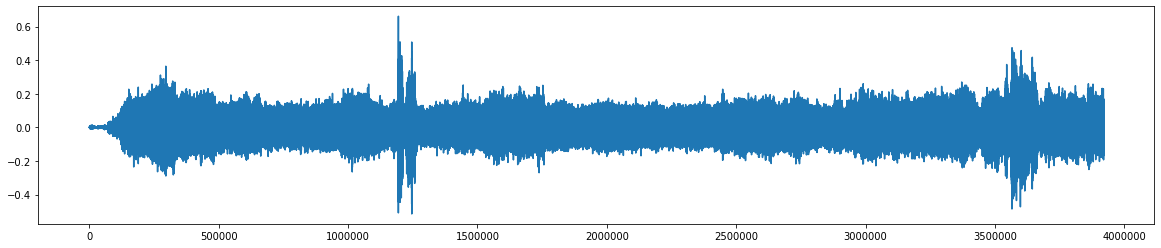

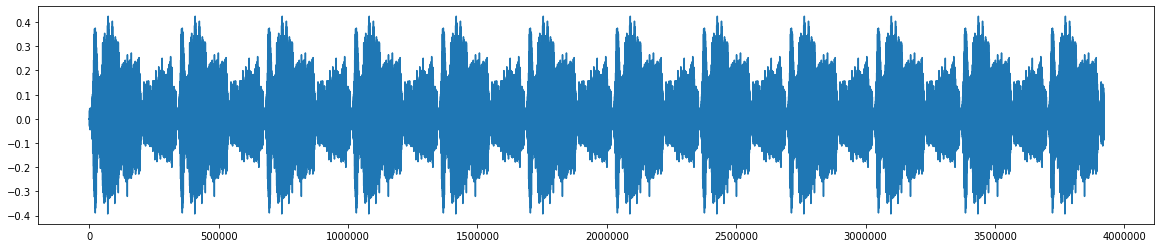

In [17]:
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(data)


fig, ax = plt.subplots(figsize=(20,4))
ax.plot(noise_data)

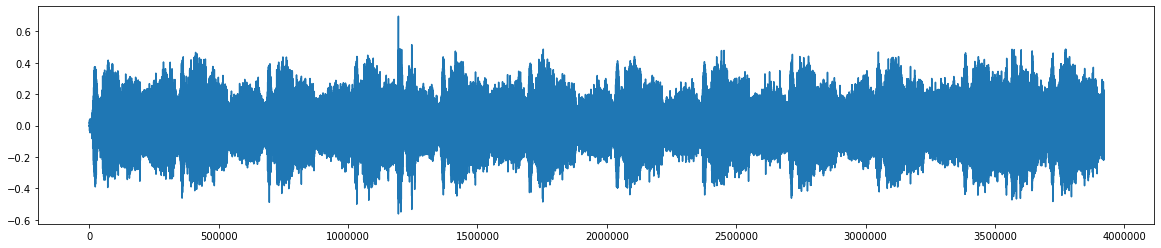

In [18]:
noise_len = 245 # seconds
noise = noise_data
noise_clip = noise[:rate*noise_len]
audio_clip_band_limited = data+noise
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(audio_clip_band_limited)
#IPython.display.Audio(data=data, rate=rate)

In [19]:
import time
from datetime import timedelta as td


def _stft(y, n_fft, hop_length, win_length):
    return librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)


def _istft(y, hop_length, win_length):
    return librosa.istft(y, hop_length, win_length)


def _amp_to_db(x):
    return librosa.core.amplitude_to_db(x, ref=1.0, amin=1e-20, top_db=80.0)


def _db_to_amp(x,):
    return librosa.core.db_to_amplitude(x, ref=1.0)


def plot_spectrogram(signal, title):
    fig, ax = plt.subplots(figsize=(20, 4))
    cax = ax.matshow(
        signal,
        origin="lower",
        aspect="auto",
        cmap=plt.cm.seismic,
        vmin=-1 * np.max(np.abs(signal)),
        vmax=np.max(np.abs(signal)),
    )
    fig.colorbar(cax)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()


def plot_statistics_and_filter(
    mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
):
    fig, ax = plt.subplots(ncols=2, figsize=(20, 4))
    plt_mean, = ax[0].plot(mean_freq_noise, label="Mean power of noise")
    plt_std, = ax[0].plot(std_freq_noise, label="Std. power of noise")
    plt_std, = ax[0].plot(noise_thresh, label="Noise threshold (by frequency)")
    ax[0].set_title("Threshold for mask")
    ax[0].legend()
    cax = ax[1].matshow(smoothing_filter, origin="lower")
    fig.colorbar(cax)
    ax[1].set_title("Filter for smoothing Mask")
    plt.show()


def removeNoise(
    audio_clip,
    noise_clip,
    n_grad_freq=2,
    n_grad_time=4,
    n_fft=2048,
    win_length=2048,
    hop_length=512,
    n_std_thresh=1.5,
    prop_decrease=1.0,
    verbose=False,
    visual=False,
):
    """Remove noise from audio based upon a clip containing only noise

    Args:
        audio_clip (array): The first parameter.
        noise_clip (array): The second parameter.
        n_grad_freq (int): how many frequency channels to smooth over with the mask.
        n_grad_time (int): how many time channels to smooth over with the mask.
        n_fft (int): number audio of frames between STFT columns.
        win_length (int): Each frame of audio is windowed by `window()`. The window will be of length `win_length` and then padded with zeros to match `n_fft`..
        hop_length (int):number audio of frames between STFT columns.
        n_std_thresh (int): how many standard deviations louder than the mean dB of the noise (at each frequency level) to be considered signal
        prop_decrease (float): To what extent should you decrease noise (1 = all, 0 = none)
        visual (bool): Whether to plot the steps of the algorithm

    Returns:
        array: The recovered signal with noise subtracted

    """
    if verbose:
        start = time.time()
    # STFT over noise
    noise_stft = _stft(noise_clip, n_fft, hop_length, win_length)
    noise_stft_db = _amp_to_db(np.abs(noise_stft))  # convert to dB
    # Calculate statistics over noise
    mean_freq_noise = np.mean(noise_stft_db, axis=1)
    std_freq_noise = np.std(noise_stft_db, axis=1)
    noise_thresh = mean_freq_noise + std_freq_noise * n_std_thresh
    if verbose:
        print("STFT on noise:", td(seconds=time.time() - start))
        start = time.time()
    # STFT over signal
    if verbose:
        start = time.time()
    sig_stft = _stft(audio_clip, n_fft, hop_length, win_length)
    sig_stft_db = _amp_to_db(np.abs(sig_stft))
    if verbose:
        print("STFT on signal:", td(seconds=time.time() - start))
        start = time.time()
    # Calculate value to mask dB to
    mask_gain_dB = np.min(_amp_to_db(np.abs(sig_stft)))
    print(noise_thresh, mask_gain_dB)
    # Create a smoothing filter for the mask in time and frequency
    smoothing_filter = np.outer(
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_freq + 1, endpoint=False),
                np.linspace(1, 0, n_grad_freq + 2),
            ]
        )[1:-1],
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_time + 1, endpoint=False),
                np.linspace(1, 0, n_grad_time + 2),
            ]
        )[1:-1],
    )
    smoothing_filter = smoothing_filter / np.sum(smoothing_filter)
    # calculate the threshold for each frequency/time bin
    db_thresh = np.repeat(
        np.reshape(noise_thresh, [1, len(mean_freq_noise)]),
        np.shape(sig_stft_db)[1],
        axis=0,
    ).T
    # mask if the signal is above the threshold
    sig_mask = sig_stft_db < db_thresh
    if verbose:
        print("Masking:", td(seconds=time.time() - start))
        start = time.time()
    # convolve the mask with a smoothing filter
    sig_mask = scipy.signal.fftconvolve(sig_mask, smoothing_filter, mode="same")
    sig_mask = sig_mask * prop_decrease
    if verbose:
        print("Mask convolution:", td(seconds=time.time() - start))
        start = time.time()
    # mask the signal
    sig_stft_db_masked = (
        sig_stft_db * (1 - sig_mask)
        + np.ones(np.shape(mask_gain_dB)) * mask_gain_dB * sig_mask
    )  # mask real
    sig_imag_masked = np.imag(sig_stft) * (1 - sig_mask)
    sig_stft_amp = (_db_to_amp(sig_stft_db_masked) * np.sign(sig_stft)) + (
        1j * sig_imag_masked
    )
    if verbose:
        print("Mask application:", td(seconds=time.time() - start))
        start = time.time()
    # recover the signal
    recovered_signal = _istft(sig_stft_amp, hop_length, win_length)
    recovered_spec = _amp_to_db(
        np.abs(_stft(recovered_signal, n_fft, hop_length, win_length))
    )
    if verbose:
        print("Signal recovery:", td(seconds=time.time() - start))
    if visual:
        plot_spectrogram(noise_stft_db, title="Noise")
    if visual:
        plot_statistics_and_filter(
            mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
        )
    if visual:
        plot_spectrogram(sig_stft_db, title="Signal")
    if visual:
        plot_spectrogram(sig_mask, title="Mask applied")
    if visual:
        plot_spectrogram(sig_stft_db_masked, title="Masked signal")
    if visual:
        plot_spectrogram(recovered_spec, title="Recovered spectrogram")
    return recovered_signal

STFT on noise: 0:00:00.256827
STFT on signal: 0:00:00.226595
[ -6.576002  -9.057995  -8.928466 ... -47.319733 -47.26215  -47.09536 ] -36.677032
Masking: 0:00:00.136724
Mask convolution: 0:00:00.473109
Mask application: 0:00:00.416347
Signal recovery: 0:00:00.421861


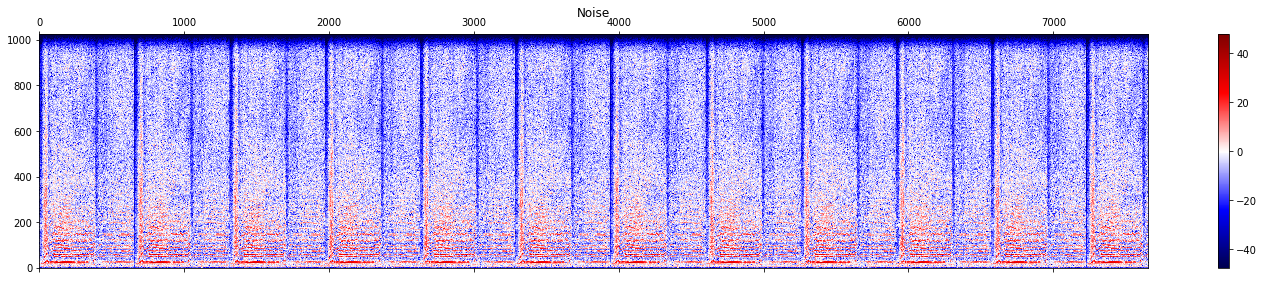

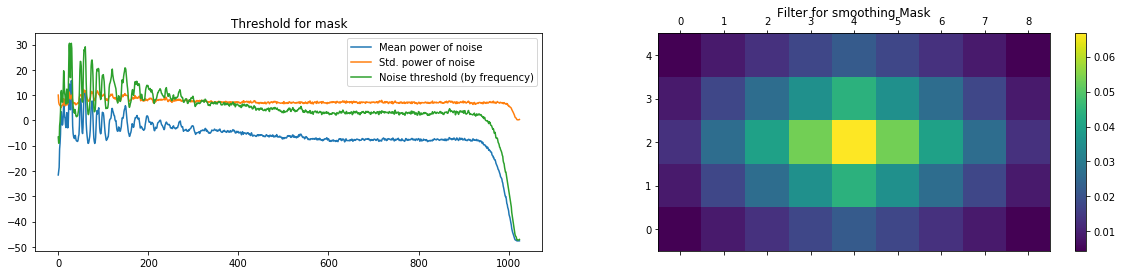

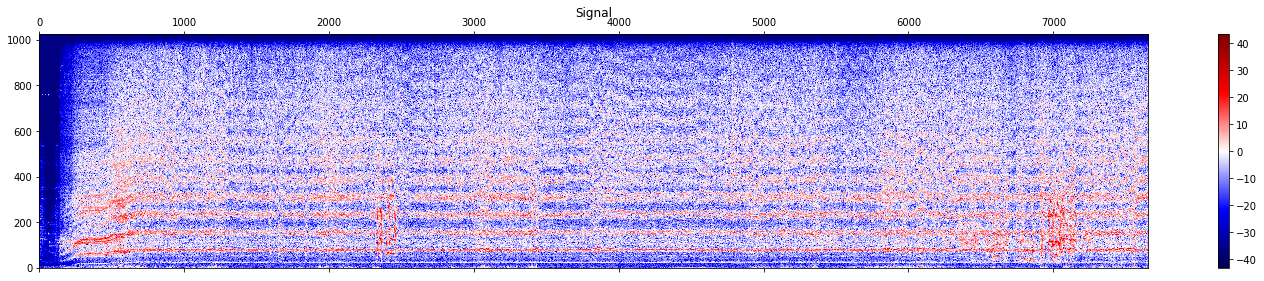

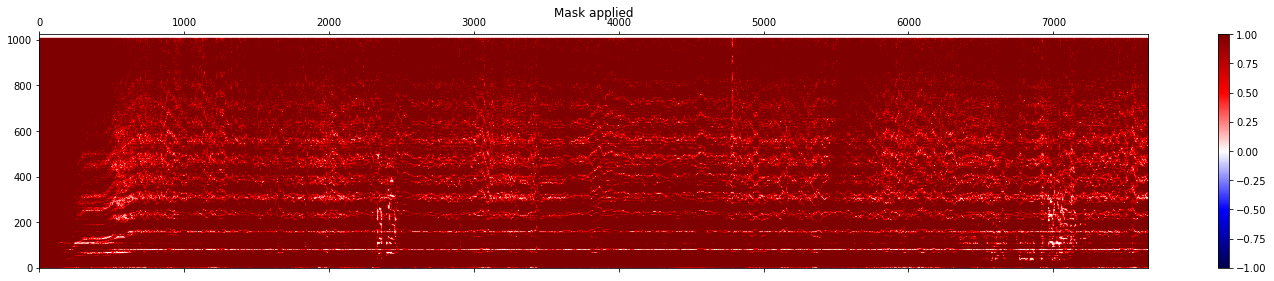

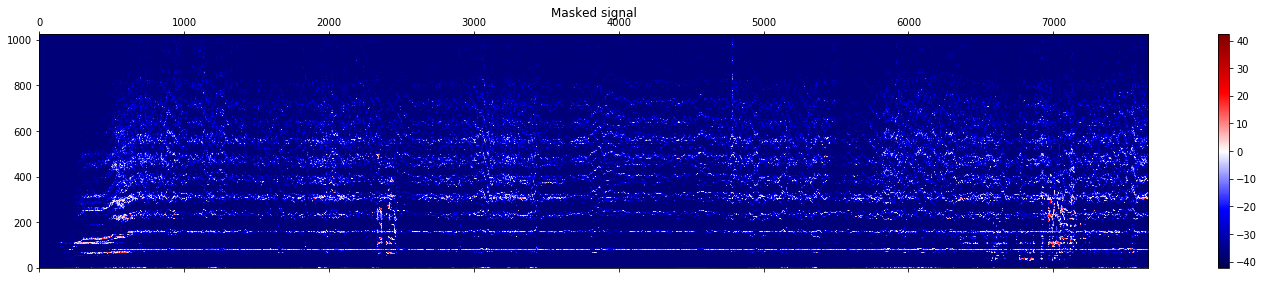

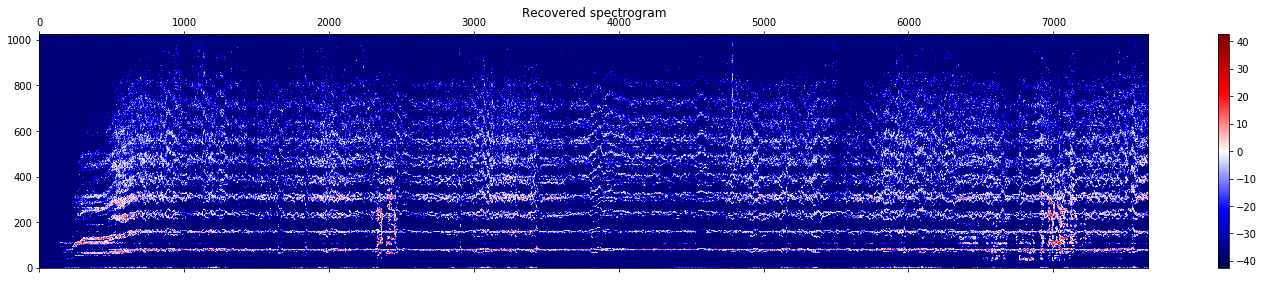

In [20]:
output = removeNoise(audio_clip=data, noise_clip=noise_data,verbose=True,visual=True)

In [21]:


# play back a sample of the song
#IPython.display.Audio(data=output, rate=44100)
librosa.output.write_wav("output.wav",output,sr)

# 음성 부분만 추출
start_time_1 = 74
end_time_1 = 79
start_time_2 = 210
end_time_2 = 220
start_time_3 = 222
end_time_3 = 228
librosa.output.write_wav("output_voice_1.wav",output[sr*start_time_1:sr*end_time_1],sr)
librosa.output.write_wav("output_voice_2.wav",output[sr*start_time_2:sr*end_time_2],sr)
librosa.output.write_wav("output_voice_3.wav",output[sr*start_time_3:sr*end_time_3],sr)

# original voice
librosa.output.write_wav("original_voice_1.wav",data[sr*start_time_1:sr*end_time_1],sr)
librosa.output.write_wav("original_voice_2.wav",data[sr*start_time_2:sr*end_time_2],sr)
librosa.output.write_wav("original_voice_3.wav",data[sr*start_time_3:sr*end_time_3],sr)




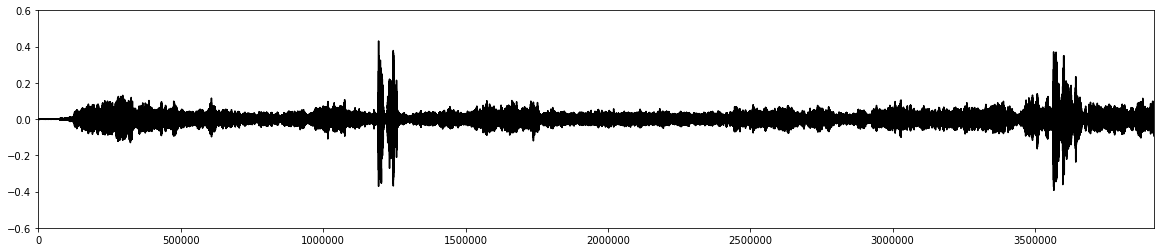

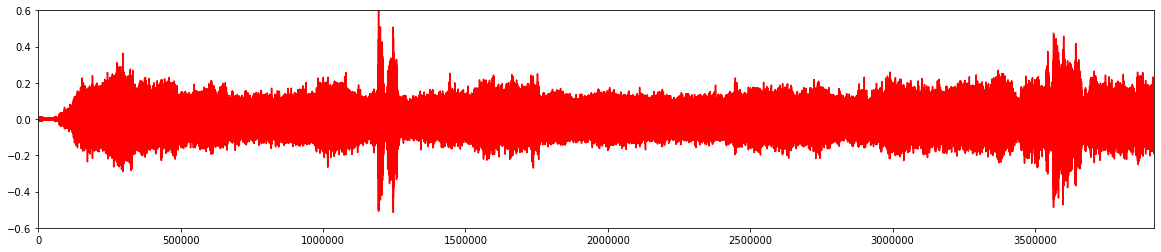

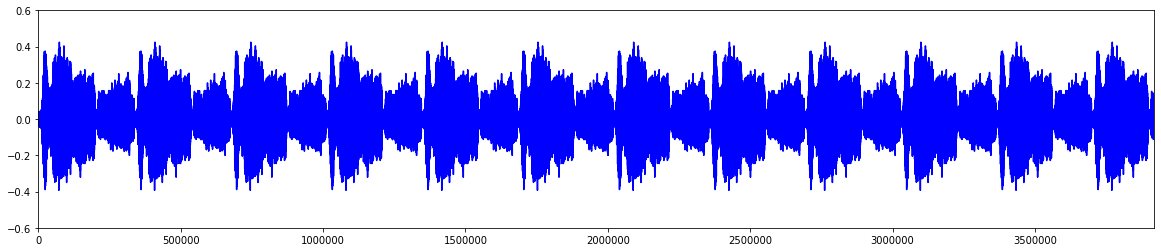

In [22]:
# 음성 부분만 추출
start_time_1 = 74
end_time_1 = 79
start_time_2 = 210
end_time_2 = 220
start_time_3 = 222
end_time_3 = 228


fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
plt.plot(output, color='black')
#plt.plot(output[sr*start_time_1:sr*end_time_1], color='red')
#plt.plot(output[sr*start_time_2:sr*end_time_2], color='red')
#plt.plot(output[sr*start_time_3:sr*end_time_3], color='red')
ax.set_xlim((0, len(output)))
ax.set_ylim((-0.6, 0.6))
plt.show()

fig, ax = plt.subplots(figsize=(20,4))
plt.plot(data, color='red')
ax.set_xlim((0, len(data)))
ax.set_ylim((-0.6, 0.6))
plt.show()


fig, ax = plt.subplots(figsize=(20,4))
plt.plot(noise_data, color='blue')
ax.set_xlim((0, len(noise_data)))
ax.set_ylim((-0.6, 0.6))
plt.show()



# librosa.display.waveplot(data, sr=sr, x_axis='time', alpha=0.4)


16000


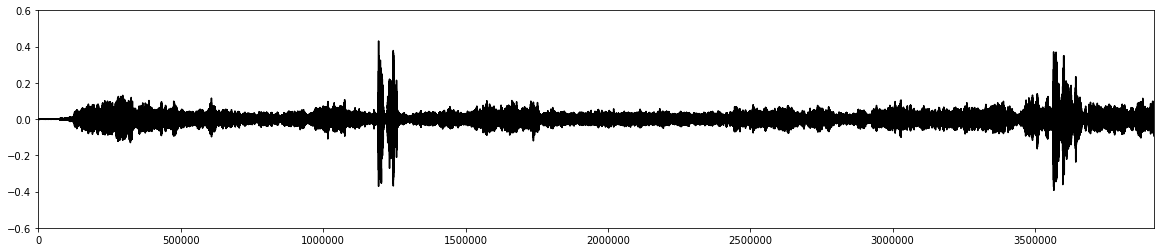

In [23]:
# 음성 부분만 추출
start_time_1 = 74
end_time_1 = 79
start_time_2 = 210
end_time_2 = 220
start_time_3 = 222
end_time_3 = 228
print(sr)


# 특정 구간 강조
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
plt.plot(output, color='black')
#plt.axvspan(output[sr*start_time_1:sr*end_time_1], output[sr*start_time_1:sr*end_time_1], color='red')
#plt.plot(output[sr*start_time_1:sr*end_time_1], color='red')
#plt.plot(output[sr*start_time_2:sr*end_time_2], color='red')
#plt.plot(output[sr*start_time_3:sr*end_time_3], color='red')
ax.set_xlim((0, len(output)))
ax.set_ylim((-0.6, 0.6))
plt.show()

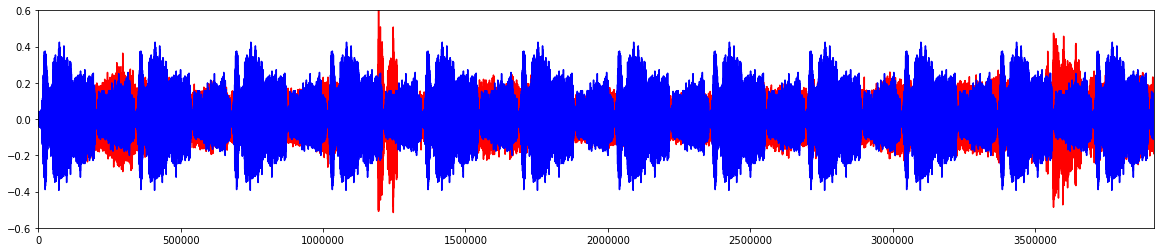

In [24]:
fig, ax = plt.subplots(figsize=(20,4))
plt.plot(data, color='red')
ax.set_xlim((0, len(data)))
ax.set_ylim((-0.6, 0.6))

plt.plot(noise_data, color='blue')
plt.show()

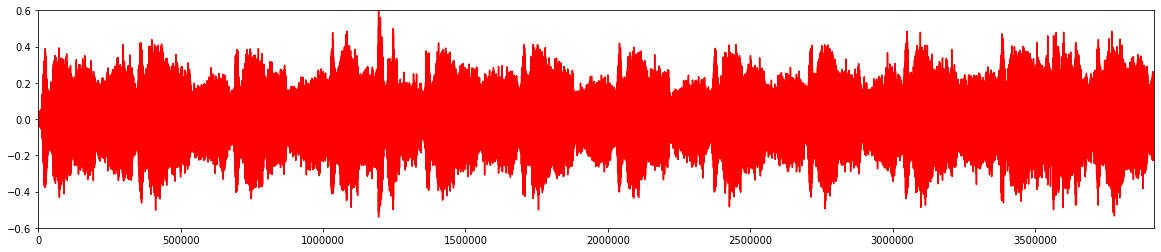

In [25]:
fig, ax = plt.subplots(figsize=(20,4))
plt.plot(data-noise_data, color='red')
ax.set_xlim((0, len(data)))
ax.set_ylim((-0.6, 0.6))
plt.show()

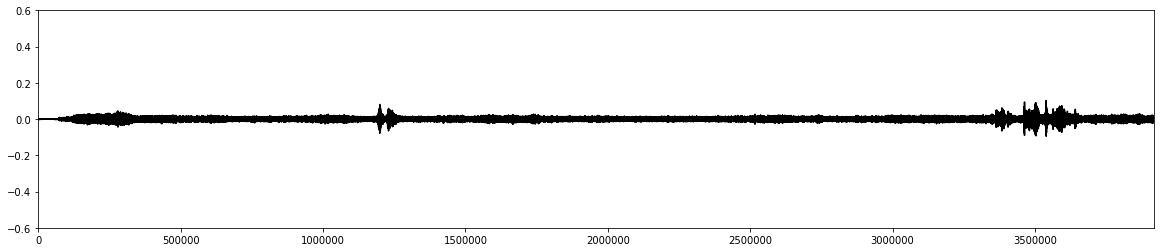

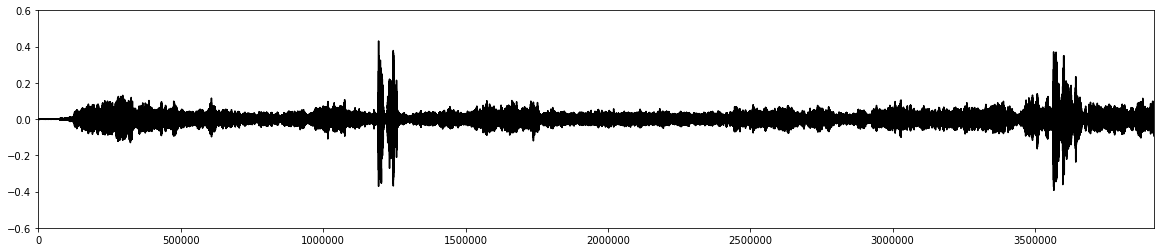

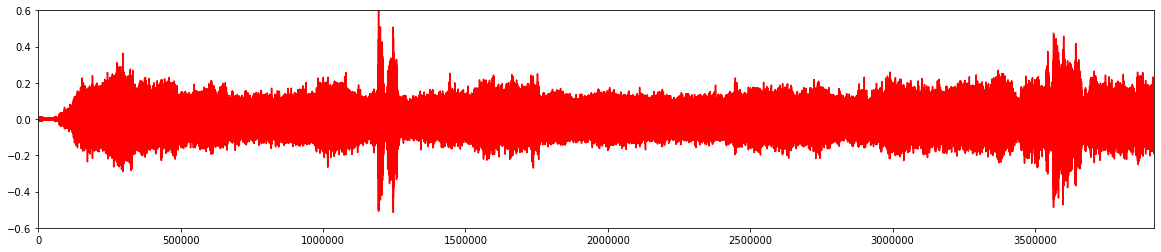

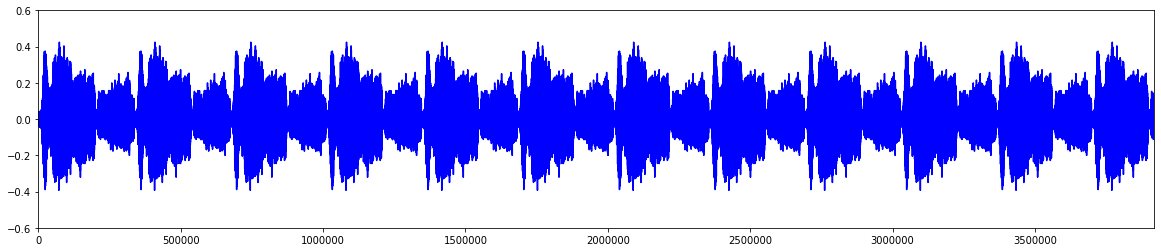

In [26]:
from scipy.signal import butter, lfilter
# https://hadaney.tistory.com/7

def butter_bandpass(lowcut, highcut, fs, order=3):
    nyq = 0.5*fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b,a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


band_data = butter_bandpass_filter(data, 400, 1200, 44100, 3)
band_output_data = butter_bandpass_filter(data, 200, 800, 44100, 3)



# 음성 부분만 추출
start_time_1 = 74
end_time_1 = 79
start_time_2 = 210
end_time_2 = 220
start_time_3 = 222
end_time_3 = 228
librosa.output.write_wav("band_voice_1.wav",band_data[sr*start_time_1:sr*end_time_1]*10,sr)
librosa.output.write_wav("band_voice_2.wav",band_data[sr*start_time_2:sr*end_time_2]*10,sr)
librosa.output.write_wav("band_voice_3.wav",band_data[sr*start_time_3:sr*end_time_3]*10,sr)


librosa.output.write_wav("band_output_voice_1.wav",band_output_data[sr*start_time_1:sr*end_time_1]*10,sr)
librosa.output.write_wav("band_output_voice_2.wav",band_output_data[sr*start_time_2:sr*end_time_2]*10,sr)
librosa.output.write_wav("band_output_voice_3.wav",band_output_data[sr*start_time_3:sr*end_time_3]*10,sr)


fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
plt.plot(band_data, color='black')
ax.set_xlim((0, len(band_data)))
ax.set_ylim((-0.6, 0.6))
plt.show()

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,4))
plt.plot(output, color='black')
ax.set_xlim((0, len(output)))
ax.set_ylim((-0.6, 0.6))
plt.show()

fig, ax = plt.subplots(figsize=(20,4))
plt.plot(data, color='red')
ax.set_xlim((0, len(data)))
ax.set_ylim((-0.6, 0.6))
plt.show()

fig, ax = plt.subplots(figsize=(20,4))
plt.plot(noise_data, color='blue')
ax.set_xlim((0, len(noise_data)))
ax.set_ylim((-0.6, 0.6))
plt.show()



Text(0.5, 1.0, 'Power spectrum')

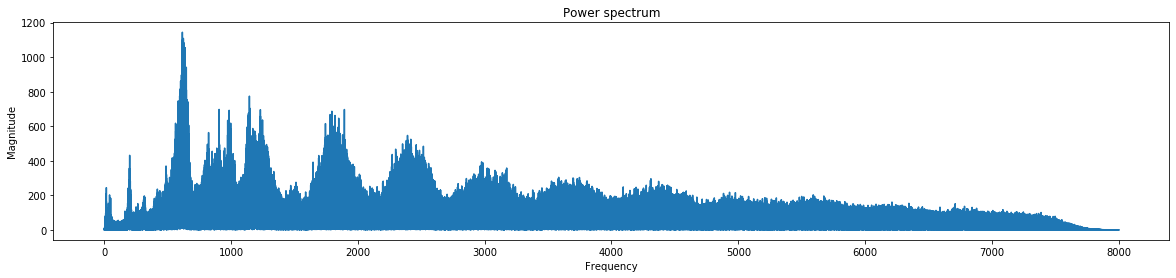

In [27]:


fft = np.fft.fft(data)


# 복소공간 값 절댓갑 취해서, magnitude 구하기
magnitude = np.abs(fft) 

# Frequency 값 만들기
f = np.linspace(0,sr,len(magnitude))

# 푸리에 변환을 통과한 specturm은 대칭구조로 나와서 high frequency 부분 절반을 날려고 앞쪽 절반만 사용한다.
left_spectrum = magnitude[:int(len(magnitude)/2)]
left_f = f[:int(len(magnitude)/2)]

plt.figure(figsize=(20,4))
plt.plot(left_f, left_spectrum)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum")



Text(0.5, 1.0, 'Power spectrum')

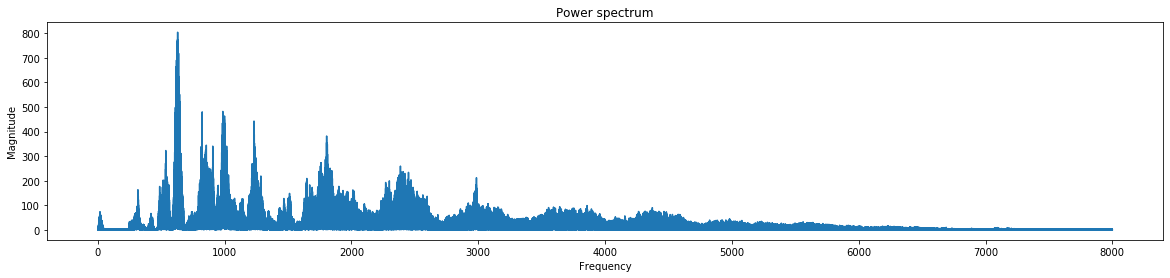

In [28]:


fft = np.fft.fft(output)


# 복소공간 값 절댓갑 취해서, magnitude 구하기
magnitude = np.abs(fft) 

# Frequency 값 만들기
f = np.linspace(0,sr,len(magnitude))

# 푸리에 변환을 통과한 specturm은 대칭구조로 나와서 high frequency 부분 절반을 날려고 앞쪽 절반만 사용한다.
left_spectrum = magnitude[:int(len(magnitude)/2)]
left_f = f[:int(len(magnitude)/2)]

plt.figure(figsize=(20,4))
plt.plot(left_f, left_spectrum)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum")



In [29]:
from scipy import signal

def notch_pass_filter(data, center, interval=20, sr=44100, normalized=False):
    center = center / (sr/2) if normalized else center
    b, a = signal.irrnotch(center, center/interval, sr)
    filtered_data = signal.lfilter(b,a,data)
    return filtered_data

notch_pass_filter(data, 1100, 20, 44100, True)

AttributeError: module 'scipy.signal' has no attribute 'irrnotch'